# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load data

In [3]:
%pwd

'F:\\Jupyterlab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [4]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

magnitude = 1 # Take this from the 1. EDA & Feauture engineering notebook. It's the factor where gasPower has been scaled with to the power 10.

In [5]:
df.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,16,1,1


# Preprocessing
Prepare the data for the used model.

In [6]:
data = df.copy()

# datetime info to categorical

In [7]:
columns_to_category = ['hour', 'dayofweek', 'season']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

# One hot encoding // dummy variables
One hot encode the categorical feautures.

In [8]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,...,1,0,0,0,0,0,1,0,0,0


# Preprocessing, data to RNN format
Setting the `look_back`, `test_size` and some other parameters.  
Remember how the `df_to_lstm_rnn_format()` function splits the data into train & test and also has the ability to scale the X data per column.

In [9]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
train_size = 0.7

X_train, y_train, X_test, y_test = df_to_cnn_rnn_format(df=data, train_size=train_size, look_back=look_back, target_column='gasPower', scale_X=True)

Taking a look of the train shape.  
There are (number of samples, rows, columns)

In [10]:
X_train.shape

(4326, 120, 44)

# Visualization of the train & test set target values

# The complete dataset

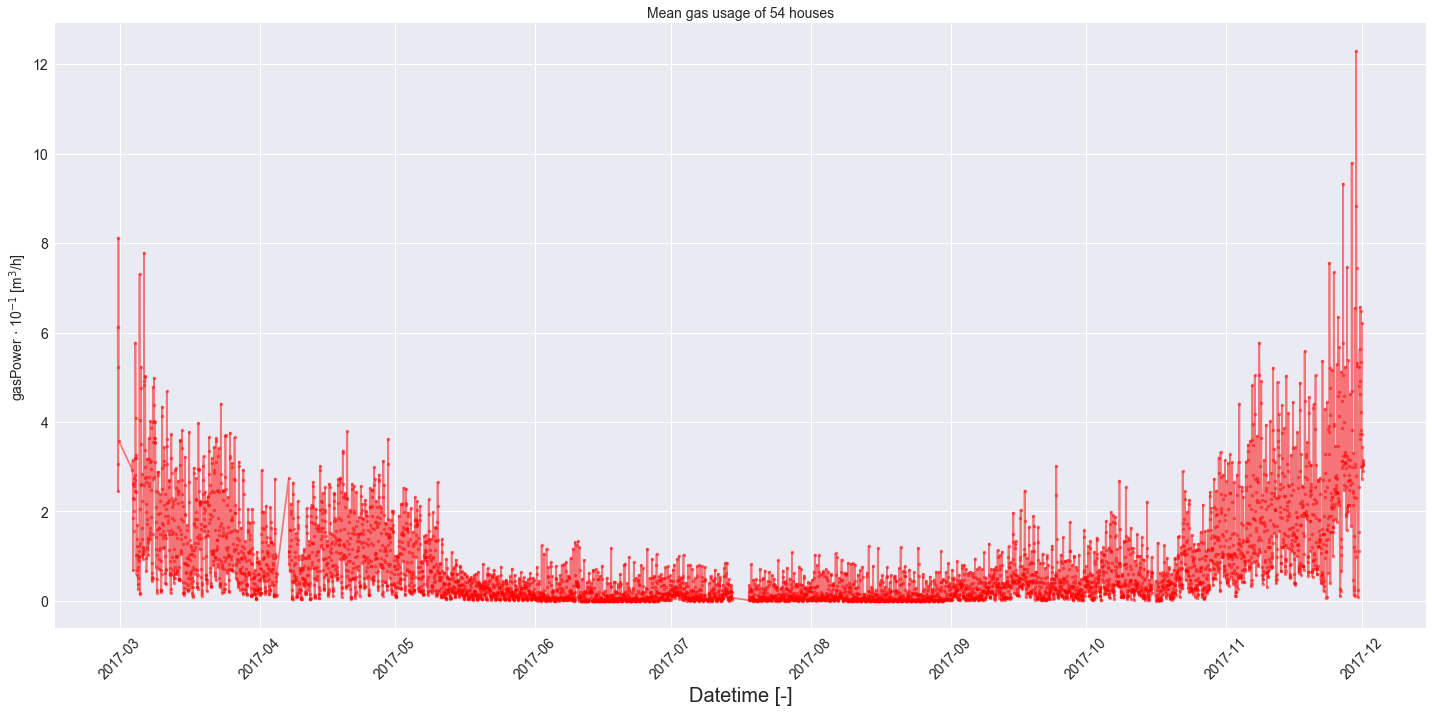

In [11]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Mean gas usage of 54 houses', fontsize=14)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# The train & test set

`TODO: Fix te look_back time difference.`  
For example, when loockback is 120 days, X_train length will be 4446 and y_train 4326...  
y_train is 120 shorter than X_train because the first 120 y values cannot be predicted due there not being 120 historical X values...  
So in the plots below there might be a 120 hour datetime difference with the actual datetime.  

In [17]:
"""
Get the X_train and X_test datetime values
"""
split_index = int(data.shape[0]*train_size)

X_train_values = data[:split_index] # get the datetime values of X_train
X_test_values = data[split_index:] # get the datetime values of X_train

In [18]:
X_train_values.shape, y_train.shape

((4446, 45), (4326,))

In [19]:
X_test_values.shape, y_test.shape

((1906, 45), (1786,))

Temporary fix for the datetime length difference.

In [20]:
datetime_difference = len(X_train_values) - len(y_train)
X_train_values = X_train_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_train_values.shape, y_train.shape

datetime_difference = len(X_test_values) - len(y_test)
X_test_values = X_test_values[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
X_test_values.shape, y_test.shape

((1786, 45), (1786,))

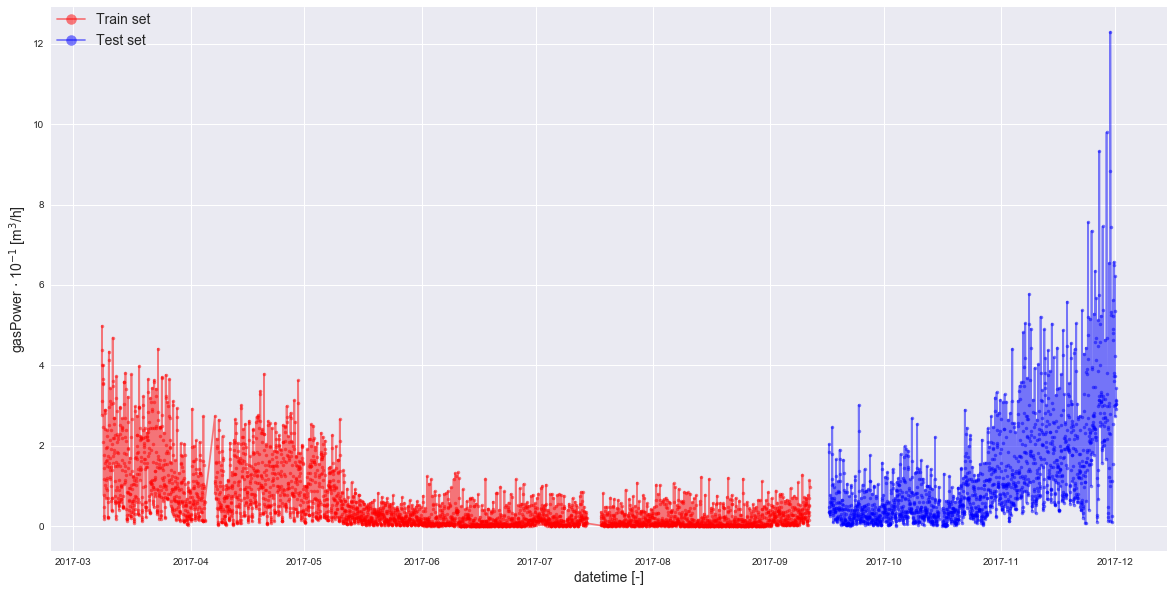

In [21]:
"""
Create the plot
"""
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [22]:
# Create model
model = Sequential()

model.add(CuDNNLSTM(8, input_shape=(look_back, num_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(CuDNNLSTM(8, return_sequences=True, kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(CuDNNLSTM(8, return_sequences=False, kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.2))


model.add(Dense(32, kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(16, kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.2))

model.add(Dense(1))

In [16]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 200
bs = 2**13
lr = 1e-2
print(bs)

8192


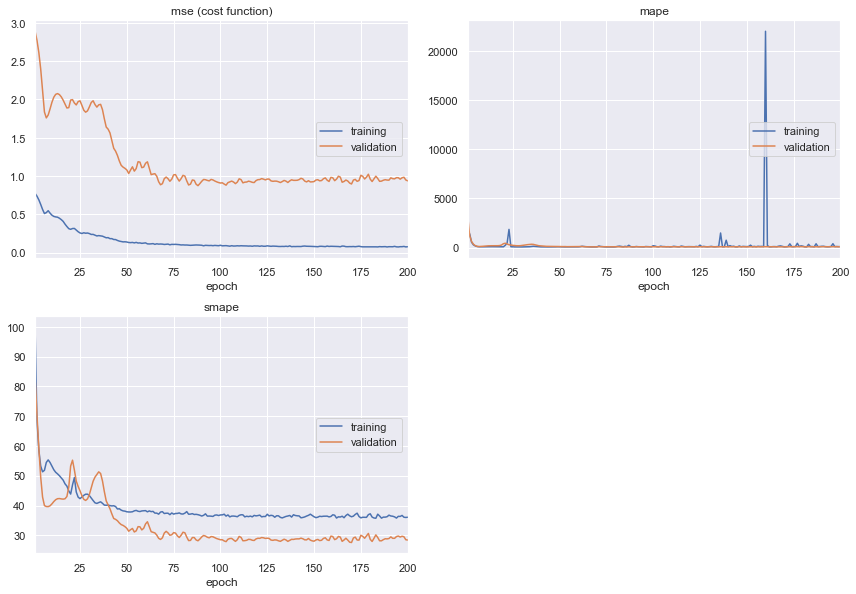

mse (cost function):
training   (min:    0.075, max:    0.775, cur:    0.078)
validation (min:    0.875, max:    2.889, cur:    0.938)

mape:
training   (min:   66.660, max:      inf, cur:  105.818)
validation (min:   72.891, max: 3134.553, cur:   85.602)

smape:
training   (min:   35.723, max:   99.991, cur:   36.068)
validation (min:   27.580, max:   83.224, cur:   28.421)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 120, 8)            1600      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 120, 8)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 8)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 120, 8)            576       
____________________________

In [17]:
# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)

# compile & fit
model.compile(optimizer=adam, loss = ['mse'], metrics=[mape, smape])


early_stopping_monitor = EarlyStopping(patience=5000)



model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_test, y_test),
         verbose=1, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

# Create plot

In [18]:
y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

1786/1786 [==============================] - 0s 277us/step
FINISHED


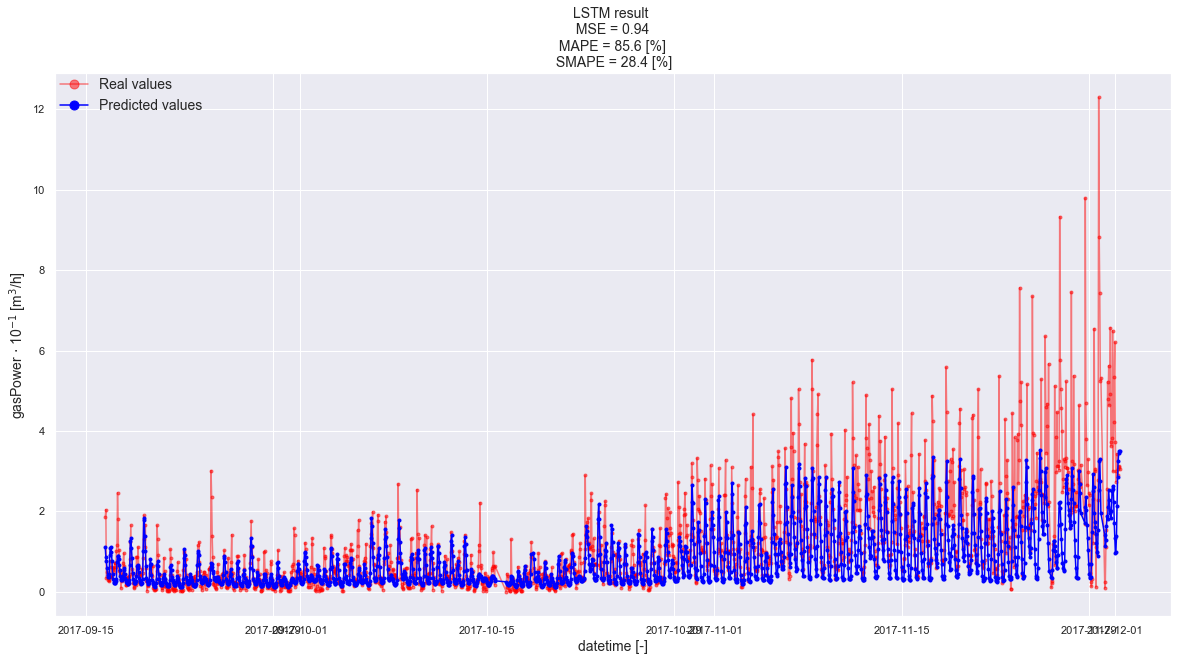

In [19]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse = model.evaluate(X_test, y_test)[0]
mape = model.evaluate(X_test, y_test)[1]
smape = model.evaluate(X_test, y_test)[2]
plt.title('LSTM result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

#plt.savefig('figures/LSTM result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

# Make the same plot, but downsample the results to a day

In [20]:
# Get results, put it in a dataframe

y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

#result.to_csv('model _results _data/LSTM_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(1786,)


In [21]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse = (1/n)*np.sum((ypred - ytrue)**2)
mape = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'LSTM result \n MSE = 193.64 \n MAPE = 41.4 [%] \n SMAPE = 15.8 [%]')

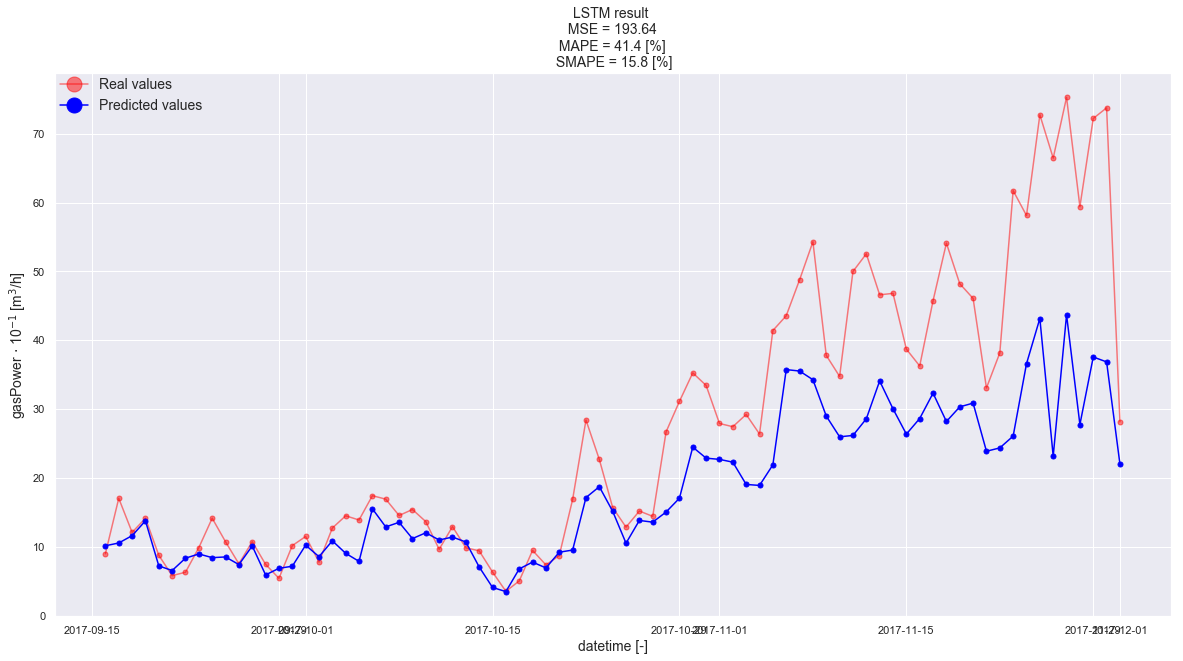

In [22]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('LSTM result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum with no dummy variables.png', dpi=1200)